
LogReg
              precision    recall  f1-score   support

           0       1.00      0.68      0.81       906
           1       0.75      1.00      0.86       894

    accuracy                           0.84      1800
   macro avg       0.88      0.84      0.83      1800
weighted avg       0.88      0.84      0.83      1800


RF
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       906
           1       1.00      1.00      1.00       894

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800


KNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       906
           1       1.00      1.00      1.00       894

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800


S

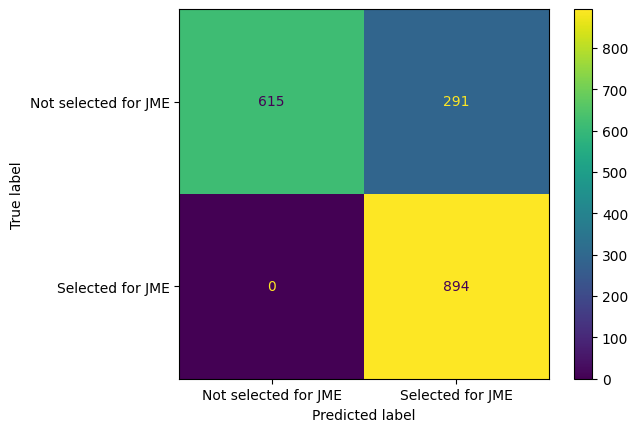

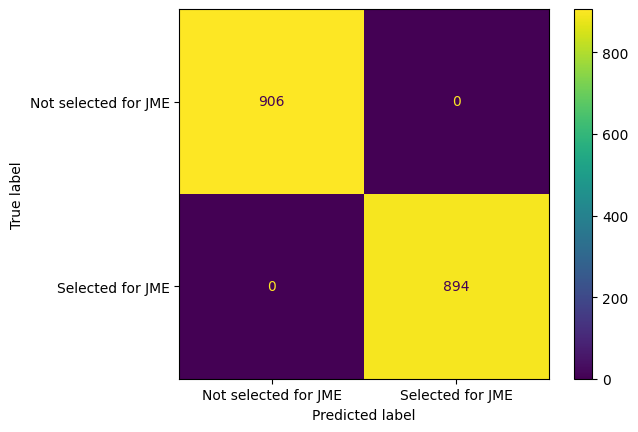

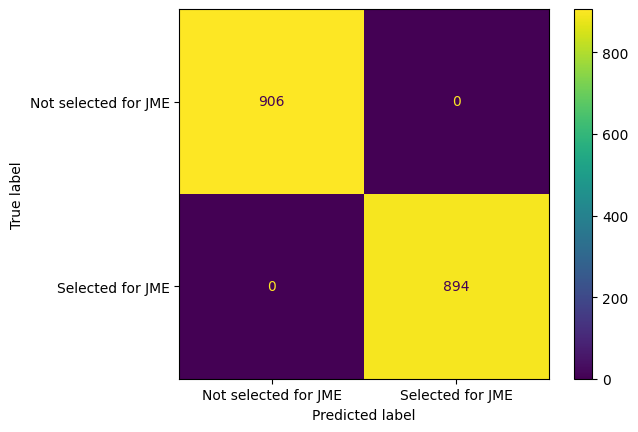

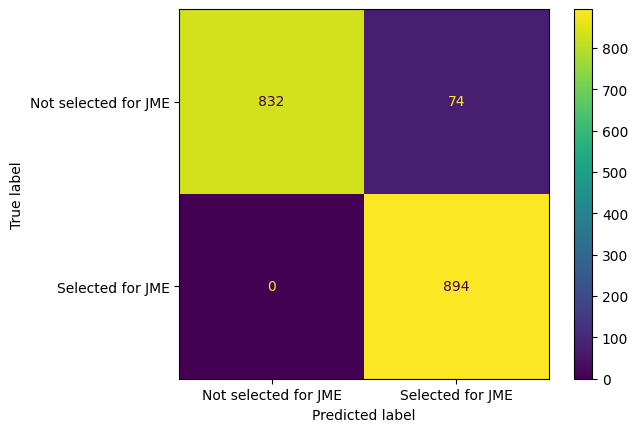

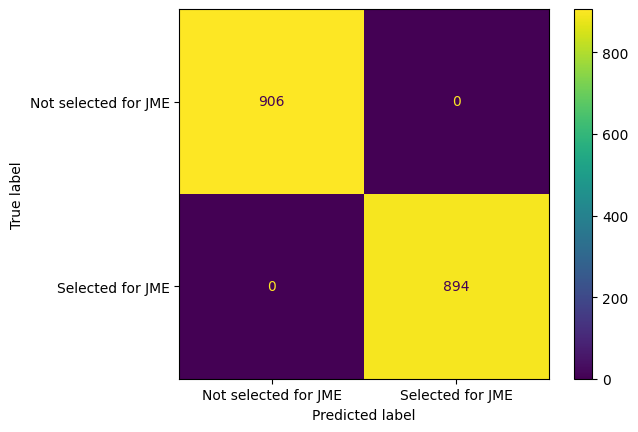

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import model_selection, metrics
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

# Load the data
data = pd.read_csv("/content/malnutrition.csv")

# Rename columns for consistency
data.columns = [col.strip() for col in data.columns]

# Handle missing values
data = data.dropna()

# Encode target variable
data['JME (Y/N)'] = data['JME (Y/N)'].apply(lambda x: 1 if x == 'Selected for JME' else 0)

# Encode categorical features
datacopy = data.copy()
le = LabelEncoder()
cat_columns = datacopy.select_dtypes(exclude='number').columns
for column in cat_columns:
    datacopy[column] = le.fit_transform(datacopy[column]) + 1

# Separate features and target
x = datacopy.drop(columns=['JME (Y/N)'])
y = datacopy['JME (Y/N)']

# Resample the dataset to balance classes
sam = RandomOverSampler(random_state=0)
x_resampled, y_resampled = sam.fit_resample(x, y)

# Standardize features
scaler = StandardScaler().fit(x_resampled)
x_resampled_scaled = scaler.transform(x_resampled)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(x_resampled_scaled, y_resampled, test_size=0.2, random_state=400)

# Define models to be evaluated
models = [
    ('LogReg', LogisticRegression(max_iter=1000)),
    ('RF', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()),
    ('MLP', MLPClassifier(max_iter=1000))
]

# Perform cross-validation and model fitting
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    print(f"\n{name}")
    print(classification_report(Y_test, y_pred))
    confusionMatrix = confusion_matrix(Y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=['Not selected for JME', 'Selected for JME'])
    cm_display.plot()

# Hyperparameter tuning for the best model (Random Forest)
param_grid = {
    'n_estimators': [25, 50],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3],
    'max_leaf_nodes': [6, 9]
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=cv)
grid_search.fit(X_train, Y_train)

# Function to find malnutrition status
def findMal(df):
    # Encode categorical features
    for column in df.select_dtypes(exclude='number').columns:
        df[column] = le.transform(df[column]) + 1

    # Transform user input using the same scaler used for training
    user_transformed = scaler.transform(df)

    # Make prediction
    prediction = grid_search.predict(user_transformed)
    Ans = "Selected for JME" if prediction[0] == 1 else "Not selected for JME"

    return Ans

In [3]:
pip install joblib

In [8]:
import joblib

# Assume grid_search is your trained model
best_model = grid_search.best_estimator_

# Save the model to a file
joblib.dump(best_model, 'best_model.pkl')

joblib.dump(le, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [5]:
print(best_model)

RandomForestClassifier(max_depth=3, max_leaf_nodes=6, n_estimators=50)


In [6]:
import joblib

# Load the model from the file
model = joblib.load('best_model.pkl')


In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Example dataframe similar to your data structure
example_df = pd.DataFrame({
    'Country Short Name': ['India'],
    'Year period': [1999],
    'Median Year': [1999],
    'Start Month': ['NOV'],
    'End Month': ['JUL'],
    'Age': [1.0],
    'Sex': ['BTSX'],
    'MUAC(IN)': [7.0],
    'WHZ': [20.0],
    'Weight(kg)': [3.5],
    'Height(in)': [50.0],
    'Head Circumference(cm)': [44.0]
})

# Encode categorical features and scale numerical features
le = LabelEncoder()
scaler = StandardScaler()

# Assume 'le' and 'scaler' are the ones used during training
for column in example_df.select_dtypes(exclude='number').columns:
    example_df[column] = le.fit_transform(example_df[column]) + 1

example_df_scaled = scaler.fit_transform(example_df)

# Make prediction
prediction = model.predict(example_df_scaled)
result = "Selected for JME" if prediction[0] == 1 else "Not selected for JME"

print(result)


Selected for JME
